In [1]:
import json

def classify_update(prev_update, current_update):
    if current_update.get('is_withdrawal', False):
        return 'WD'
    elif prev_update["path_length"] < current_update["path_length"]:
        return 'DOWN'
    elif prev_update["path_length"] > current_update["path_length"]:
        return 'UP'
    else:
        return 'FLAT'

def process_bgp_data(file_path):
    with open(file_path, 'r') as file:
        bgp_data = json.load(file)

    updates = bgp_data["data"]["updates"]
    prev_updates = {}

    for update in updates:
        source_id = update["attrs"].get("source_id", "unknown")
        target_prefix = update["attrs"].get("target_prefix", "unknown")
        key = f"{source_id}-{target_prefix}"

        is_withdrawal = update["type"] == 'W'

        path_length = 0 if is_withdrawal else len(update["attrs"].get("path", []))

        current_update_info = {"path_length": path_length, "is_withdrawal": is_withdrawal}

        classification = 'WD' if is_withdrawal else 'N/A'
        if not is_withdrawal and key in prev_updates:
            classification = classify_update(prev_updates[key], current_update_info)

        prev_updates[key] = current_update_info

        update["classification"] = classification

    output_file_path = file_path.replace('.json', '_classified.json')
    with open(output_file_path, 'w') as file:
        json.dump(bgp_data, file, indent=4)

    return output_file_path

file_path = 'ucrNRDATA.json'
output_file_path = process_bgp_data(file_path)
print(f"Classified data has been saved to {output_file_path}")


Classified data has been saved to ucrNRDATA_classified.json


In [2]:
import json
import csv

input_file_path = 'ucrNRDATA_classified.json'
output_csv_path = 'facebookJson_classified.csv'

with open(input_file_path, 'r') as file:
    bgp_data = json.load(file)

with open(output_csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Seq', 'Timestamp', 'Type', 'Source_ID', 'Target_Prefix', 'Path', 'Path_Length', 'Classification'])
    
    for update in bgp_data["data"]["updates"]:
        seq = update.get('seq', '')
        timestamp = update.get('timestamp', '')
        update_type = update.get('type', '')
        source_id = update["attrs"].get("source_id", '')
        target_prefix = update["attrs"].get("target_prefix", '')
        path = update["attrs"].get("path", [])
        path_str = json.dumps(path)
        path_length = len(path)
        classification = update.get('classification', '')
        
        writer.writerow([seq, timestamp, update_type, source_id, target_prefix, path_str, path_length, classification])

print(f"Classified updates have been saved to CSV: {output_csv_path}")


Classified updates have been saved to CSV: facebookJson_classified.csv


In [3]:
import csv
from collections import defaultdict

def detect_pattern(sequence):
    if 'WD' in sequence[1:-1]:
        return 'B'
    elif sequence.count('UP') == 1 or sequence.count('DOWN') == 1:
        return 'C'
    elif all(x == 'FLAT' for x in sequence):
        return 'F'
    return None

input_csv_path = 'facebookJson_classified.csv'
updates_by_source_target = defaultdict(list)

with open(input_csv_path, 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        source_target_key = (row['Source_ID'], row['Target_Prefix'])
        updates_by_source_target[source_target_key].append(row['Classification'])

pattern_results = []

for source_target, classifications in updates_by_source_target.items():
    if len(classifications) >= 4:
        for i in range(len(classifications) - 3):
            sequence = classifications[i:i+4]
            pattern_type = detect_pattern(sequence)
            if pattern_type:
                pattern_results.append({
                    'source_target': source_target,
                    'sequence': sequence,
                    'pattern_type': pattern_type
                })

for result in pattern_results:
    print(f"Source-Target: {result['source_target']}, Sequence: {result['sequence']}, Pattern Type: {result['pattern_type']}")


Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['N/A', 'DOWN', 'UP', 'FLAT'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['DOWN', 'UP', 'FLAT', 'DOWN'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['UP', 'FLAT', 'DOWN', 'UP'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['FLAT', 'DOWN', 'UP', 'DOWN'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['UP', 'DOWN', 'UP', 'FLAT'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['DOWN', 'UP', 'FLAT', 'DOWN'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['UP', 'FLAT', 'DOWN', 'UP'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['FLAT', 'DOWN', 'UP', 'FLAT'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Sequence: ['DOWN', 'UP', 'FLAT', 'DOWN'], Patter

In [4]:
import csv
from collections import defaultdict

def detect_pattern(sequence):
    if 'WD' in sequence[1:-1]:
        return 'B'
    elif sequence.count('UP') == 1 or sequence.count('DOWN') == 1:
        return 'C'
    elif all(x == 'FLAT' for x in sequence):
        return 'F'
    return None

input_csv_path = 'facebookJson_classified.csv'
updates_by_source_target = defaultdict(list)

with open(input_csv_path, 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        source_target_key = (row['Source_ID'], row['Target_Prefix'])
        updates_by_source_target[source_target_key].append({
            'timestamp': row['Timestamp'],
            'classification': row['Classification']
        })

pattern_results = []

for source_target, updates in updates_by_source_target.items():
    updates.sort(key=lambda x: x['timestamp'])
    classifications = [update['classification'] for update in updates]
    timestamps = [update['timestamp'] for update in updates]
    
    if len(classifications) >= 4:
        for i in range(len(classifications) - 3):
            sequence = classifications[i:i+4]
            pattern_type = detect_pattern(sequence)
            if pattern_type:
                pattern_results.append({
                    'source_target': source_target,
                    'sequence': sequence,
                    'pattern_type': pattern_type,
                    'start_time': timestamps[i],
                    'end_time': timestamps[i+3]
                })

for result in pattern_results:
    print(f"Source-Target: {result['source_target']}, Start Time: {result['start_time']}, "
          f"End Time: {result['end_time']}, Sequence: {result['sequence']}, "
          f"Pattern Type: {result['pattern_type']}")


Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Start Time: 2024-03-10T00:04:12, End Time: 2024-03-10T00:47:03, Sequence: ['N/A', 'DOWN', 'UP', 'FLAT'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Start Time: 2024-03-10T00:44:38, End Time: 2024-03-10T01:23:24, Sequence: ['DOWN', 'UP', 'FLAT', 'DOWN'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Start Time: 2024-03-10T00:45:02, End Time: 2024-03-10T01:24:23, Sequence: ['UP', 'FLAT', 'DOWN', 'UP'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Start Time: 2024-03-10T00:47:03, End Time: 2024-03-10T01:42:04, Sequence: ['FLAT', 'DOWN', 'UP', 'DOWN'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Start Time: 2024-03-10T01:24:23, End Time: 2024-03-10T01:46:46, Sequence: ['UP', 'DOWN', 'UP', 'FLAT'], Pattern Type: C
Source-Target: ('15-187.16.217.161', '140.78.0.0/16'), Start Time: 2024-03-10T01:42:04, End Time: 2024-03-10T02:24:32, S

In [5]:
import csv
from collections import defaultdict

def detect_pattern(sequence):
    if 'WD' in sequence[1:-1]:
        return 'B'
    elif sequence.count('UP') == 1 or sequence.count('DOWN') == 1:
        return 'C'
    elif all(x == 'FLAT' for x in sequence):
        return 'F'
    return None

input_csv_path = 'facebookJson_classified.csv'
updates_by_source_target = defaultdict(list)

with open(input_csv_path, 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        source_target_key = (row['Source_ID'], row['Target_Prefix'])
        updates_by_source_target[source_target_key].append({
            'timestamp': row['Timestamp'],
            'classification': row['Classification']
        })

def write_patterns_to_csv(pattern_results, output_file_path):
    with open(output_file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Source', 'Target', 'Start Time', 'End Time', 'Sequence', 'Pattern Type'])
        
        for result in pattern_results:
            writer.writerow([
                result['source_target'][0],  # Source
                result['source_target'][1],  # Target
                result['start_time'],
                result['end_time'],
                '-'.join(result['sequence']),  
                result['pattern_type']
            ])

pattern_results = []

for source_target, updates in updates_by_source_target.items():
    updates.sort(key=lambda x: x['timestamp'])
    classifications = [update['classification'] for update in updates]
    timestamps = [update['timestamp'] for update in updates]
 
    if len(classifications) >= 4:
       
        for i in range(len(classifications) - 3):
            sequence = classifications[i:i+4]
            pattern_type = detect_pattern(sequence)
            if pattern_type:
                pattern_results.append({
                    'source_target': source_target,
                    'sequence': sequence,
                    'pattern_type': pattern_type,
                    'start_time': timestamps[i],
                    'end_time': timestamps[i+3]
                })

output_file_path = 'bgp_patterns.csv'
write_patterns_to_csv(pattern_results, output_file_path)

print(f"Pattern results have been saved to {output_file_path}")


Pattern results have been saved to bgp_patterns.csv


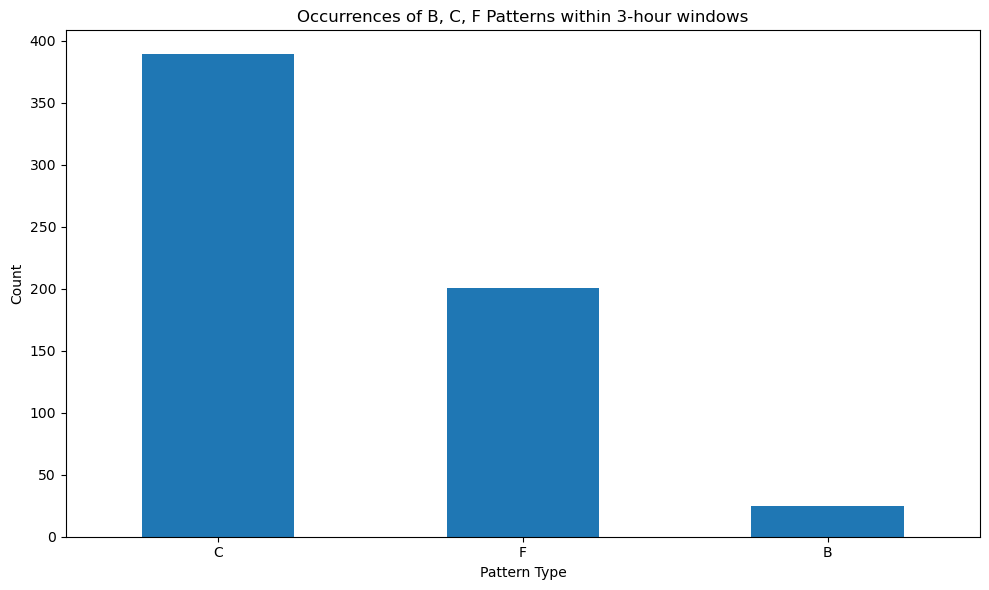

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

output_file_path = 'bgp_patterns.csv'  
df_patterns = pd.read_csv(output_file_path)

df_patterns['Start Time'] = pd.to_datetime(df_patterns['Start Time'])
df_patterns['End Time'] = pd.to_datetime(df_patterns['End Time'])
df_patterns.sort_values('Start Time', inplace=True)

three_hours = pd.Timedelta(hours=3)
df_patterns = df_patterns[df_patterns['End Time'] - df_patterns['Start Time'] <= three_hours]

pattern_counts = df_patterns['Pattern Type'].value_counts()


plt.figure(figsize=(10, 6))
pattern_counts.plot(kind='bar')
plt.title('Occurrences of B, C, F Patterns within 3-hour windows')
plt.xlabel('Pattern Type')
plt.ylabel('Count')
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()



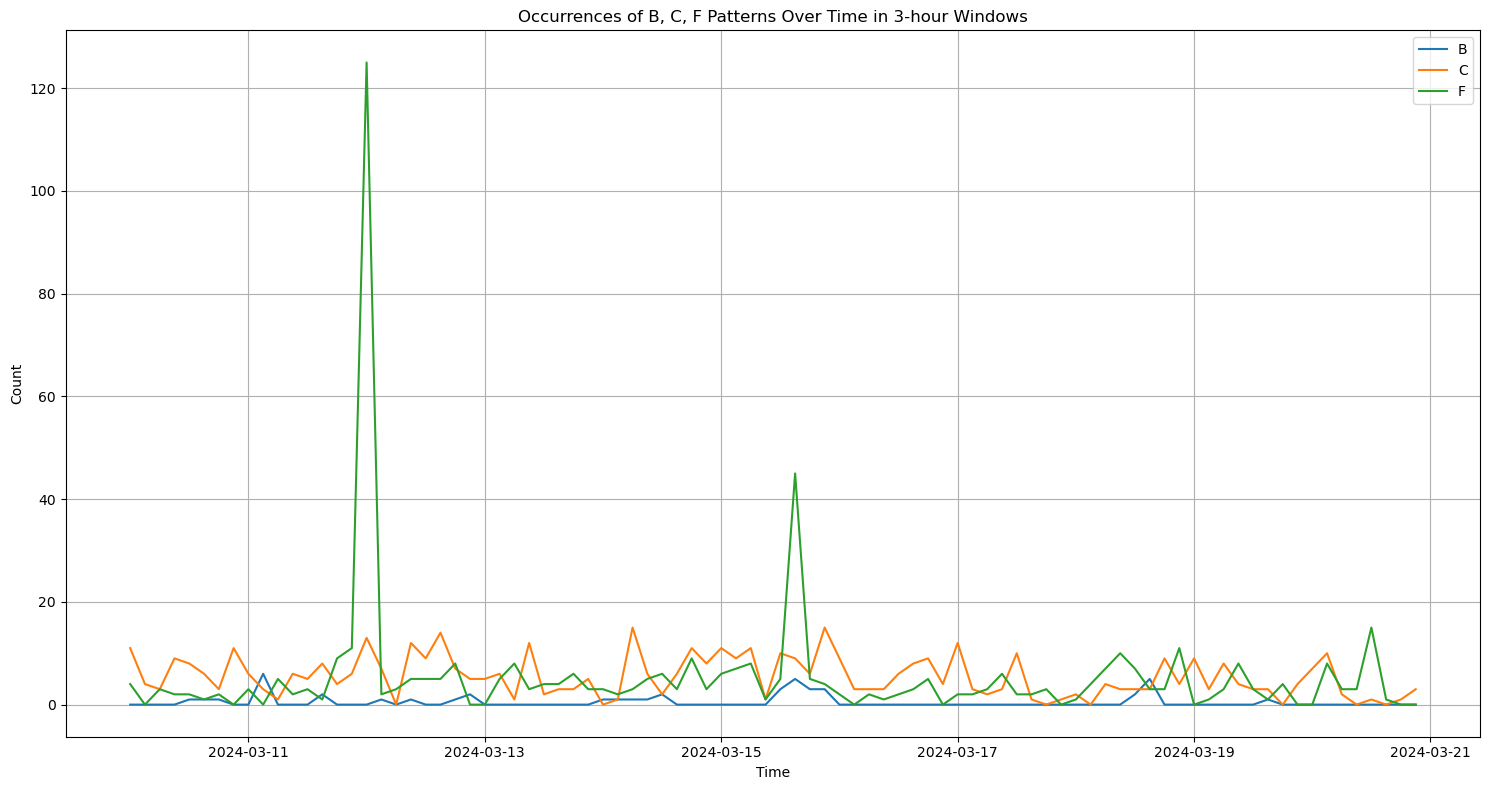

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

output_file_path = 'bgp_patterns.csv'
df_patterns = pd.read_csv(output_file_path)

df_patterns['Start Time'] = pd.to_datetime(df_patterns['Start Time'])
df_patterns.set_index('Start Time', inplace=True)

pattern_counts = df_patterns.groupby([pd.Grouper(freq='3H'), 'Pattern Type']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))

for pattern_type in pattern_counts.columns:
    plt.plot(pattern_counts.index, pattern_counts[pattern_type], label=pattern_type)

plt.title('Occurrences of B, C, F Patterns Over Time in 3-hour Windows')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('bgp_patterns_over_time.png')
plt.show()


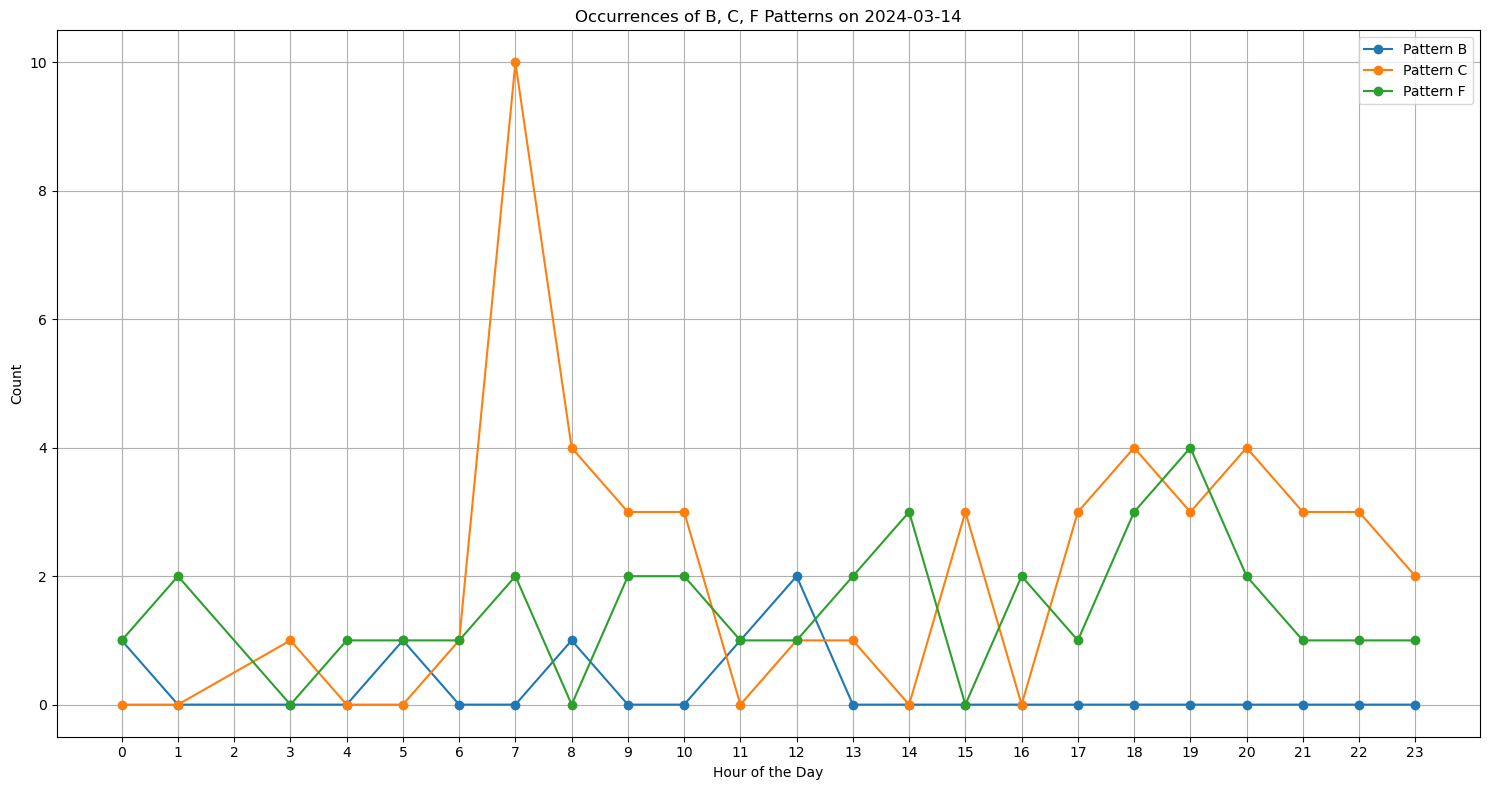

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df_patterns = pd.read_csv('bgp_patterns.csv')
df_patterns['Start Time'] = pd.to_datetime(df_patterns['Start Time'])
df_patterns.set_index('Start Time', inplace=True)

df_patterns_oct4 = df_patterns.loc['2024-03-14']
pattern_counts_oct4 = df_patterns_oct4.groupby([pd.Grouper(freq='H'), 'Pattern Type']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))

for pattern_type in pattern_counts_oct4.columns:
    plt.plot(pattern_counts_oct4.index.hour, pattern_counts_oct4[pattern_type], marker='o', label=f'Pattern {pattern_type}')

plt.title('Occurrences of B, C, F Patterns on 2024-03-14')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.savefig('bgp_patterns_oct4.png')
plt.show()


In [9]:
import pandas as pd
import ast

file_path = 'facebookJson_classified.csv'
df = pd.read_csv(file_path)

df['Path'] = df['Path'].apply(ast.literal_eval)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

df['Inter_Arrival_Time'] = df.groupby('Target_Prefix')['Timestamp'].diff().dt.total_seconds().fillna(0)

df['Hour'] = df['Timestamp'].dt.floor('H')
unique_paths_per_hour = df.groupby(['Target_Prefix', 'Hour'])['Path'].apply(lambda x: len(set(tuple(path) for path in x)))

unique_paths_per_hour_df = unique_paths_per_hour.reset_index(name='Unique_AS_Paths')

unique_paths_per_hour_df.to_csv('unique_paths_per_hour.csv', index=False)

df.to_csv('inter_arrival_times.csv', columns=['Timestamp', 'Target_Prefix', 'Inter_Arrival_Time'], index=False)


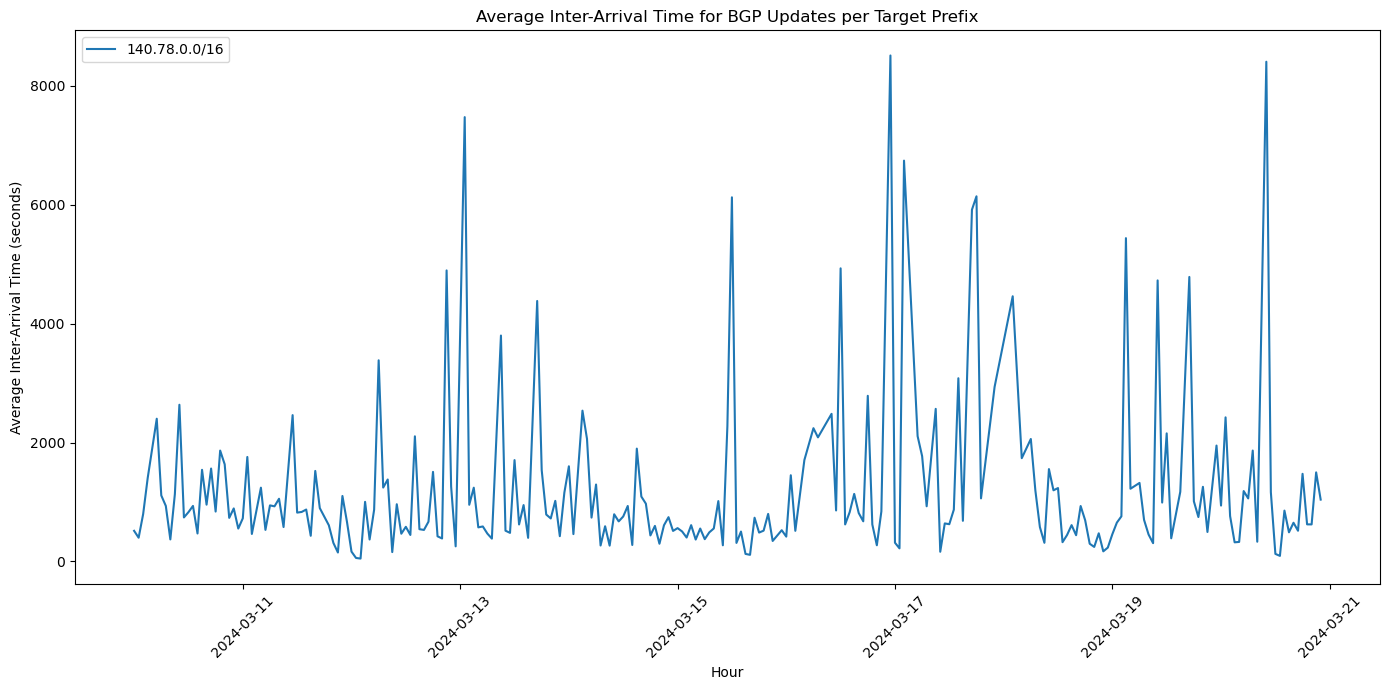

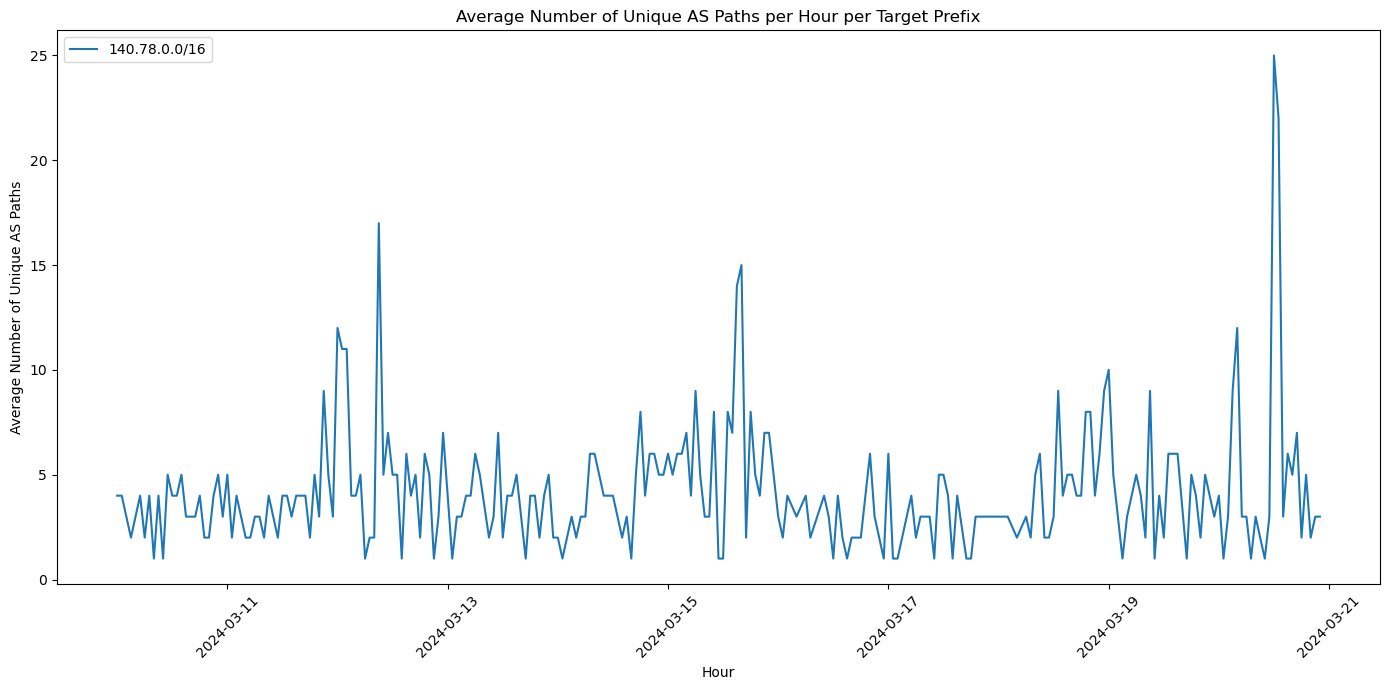

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

inter_arrival_path = 'inter_arrival_times.csv'
unique_paths_path = 'unique_paths_per_hour.csv'

df_inter_arrival = pd.read_csv(inter_arrival_path)
df_unique_paths = pd.read_csv(unique_paths_path)

df_inter_arrival['Timestamp'] = pd.to_datetime(df_inter_arrival['Timestamp'])
df_inter_arrival.set_index('Timestamp', inplace=True)

df_inter_arrival['Hour'] = df_inter_arrival.index.floor('H')
df_inter_arrival_avg = df_inter_arrival.groupby(['Target_Prefix', 'Hour'])['Inter_Arrival_Time'].mean().reset_index()

df_inter_arrival_avg.to_csv('average_inter_arrival_times.csv', index=False)

plt.figure(figsize=(14, 7))
for prefix in df_inter_arrival_avg['Target_Prefix'].unique():
    subset = df_inter_arrival_avg[df_inter_arrival_avg['Target_Prefix'] == prefix]
    plt.plot(subset['Hour'], subset['Inter_Arrival_Time'], label=prefix)
plt.xlabel('Hour')
plt.ylabel('Average Inter-Arrival Time (seconds)')
plt.title('Average Inter-Arrival Time for BGP Updates per Target Prefix')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
for prefix in df_unique_paths['Target_Prefix'].unique():
    subset = df_unique_paths[df_unique_paths['Target_Prefix'] == prefix]
    plt.plot(pd.to_datetime(subset['Hour']), subset['Unique_AS_Paths'], label=prefix)
plt.xlabel('Hour')
plt.ylabel('Average Number of Unique AS Paths')
plt.title('Average Number of Unique AS Paths per Hour per Target Prefix')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


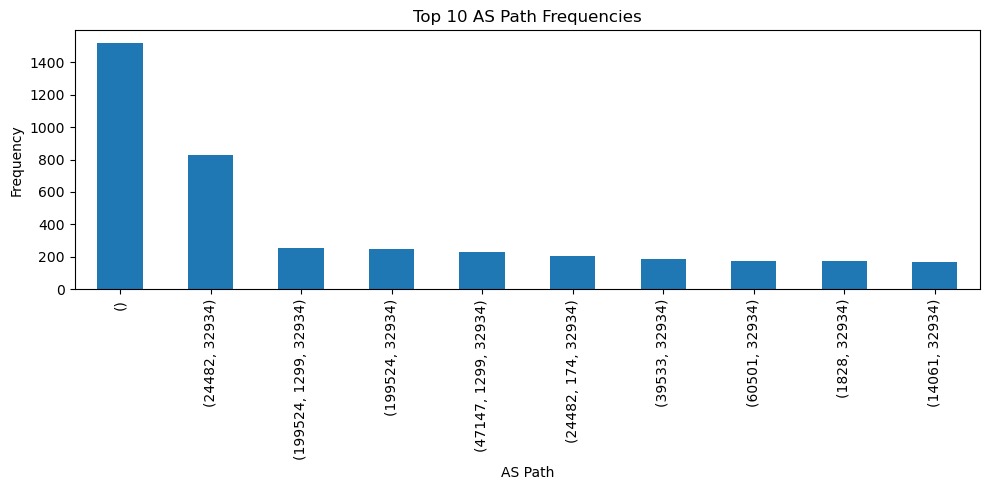

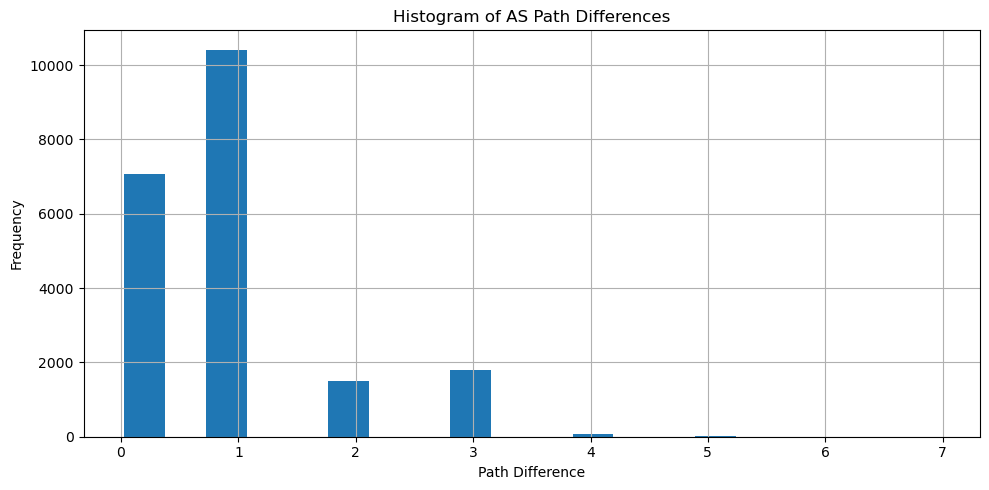

In [11]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import ast

df = pd.read_csv('facebookJson_classified.csv')
df['Path'] = df['Path'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['Update_Type'] = df['Classification']
all_paths = [tuple(path) for path in df['Path']]
path_counts = Counter(all_paths)
df['Path_Frequency'] = df['Path'].apply(lambda x: path_counts[tuple(x)])
average_path_length = df['Path_Length'].mean()
df['Path_Difference'] = df['Path_Length'].apply(lambda x: abs(x - average_path_length))
path_freq_series = pd.Series(list(path_counts.values()), index=[str(p) for p in path_counts.keys()])
path_freq_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
path_freq_series.iloc[:10].plot(kind='bar')
plt.title('Top 10 AS Path Frequencies')
plt.xlabel('AS Path')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
df['Path_Difference'].hist(bins=20)
plt.title('Histogram of AS Path Differences')
plt.xlabel('Path Difference')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

df.to_csv('bgp_measures.csv', index=False)


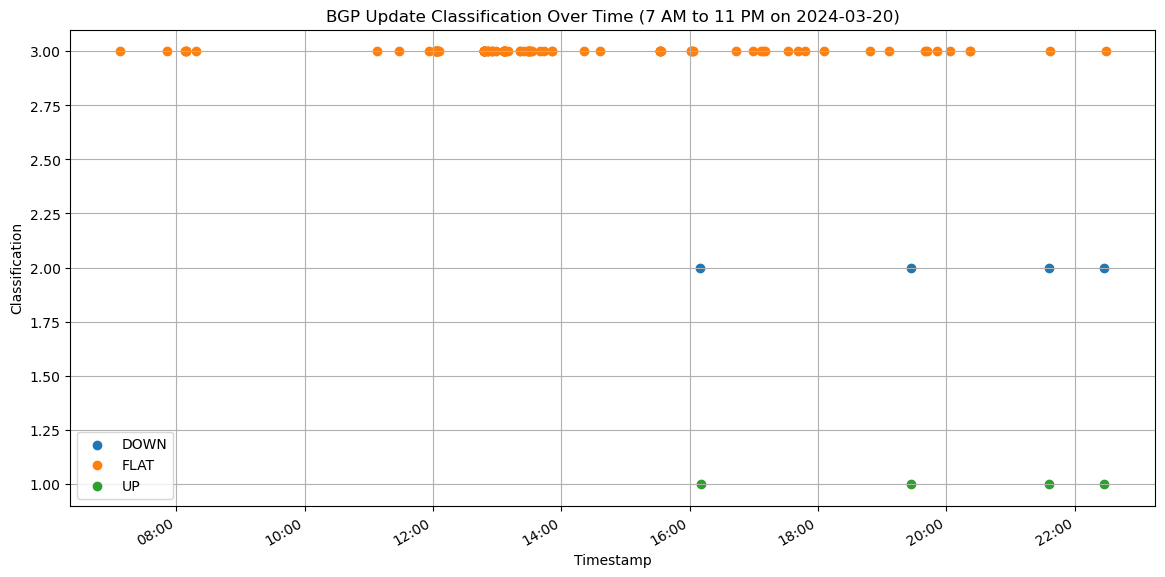

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('facebookJson_classified.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df[(df['Timestamp'] >= '2024-03-20 07:00:00') & (df['Timestamp'] <= '2024-03-20 23:00:00')]
classification_map = {'UP': 1, 'DOWN': 2, 'FLAT': 3, 'WD': 4}
df['Classification_Num'] = df['Classification'].map(classification_map)

plt.figure(figsize=(14, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for classification, group in df.groupby('Classification'):
    plt.scatter(group['Timestamp'], group['Classification_Num'], label=classification)

plt.xlabel('Timestamp')
plt.ylabel('Classification')
plt.title('BGP Update Classification Over Time (7 AM to 11 PM on 2024-03-20)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()


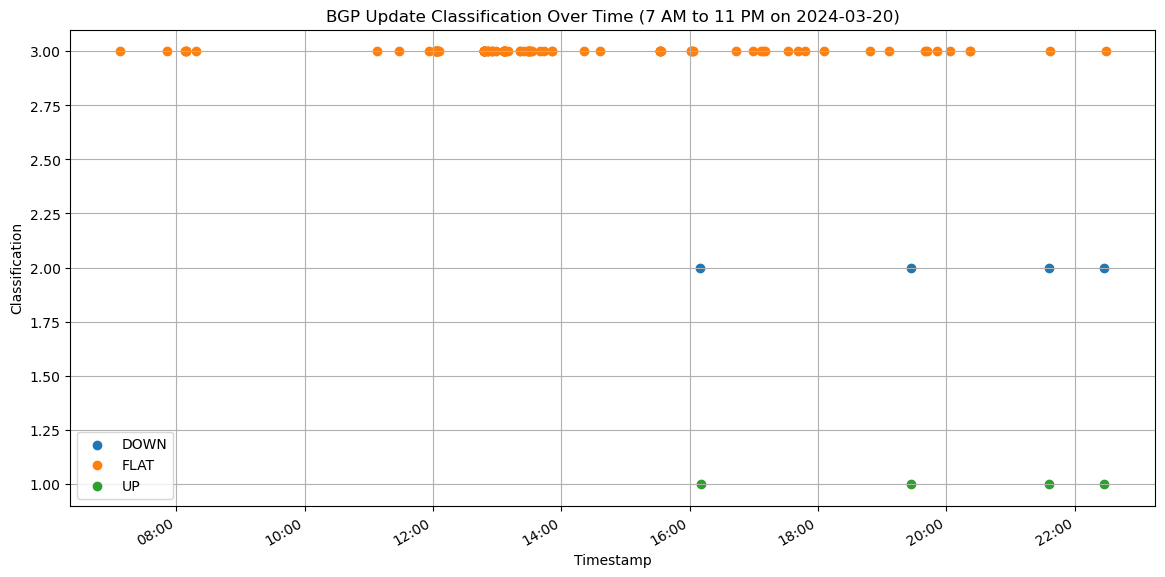

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('facebookJson_classified.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df[(df['Timestamp'] >= '2024-03-20 07:00:00') & (df['Timestamp'] <= '2024-03-20 23:00:00')]
classification_map = {'UP': 1, 'DOWN': 2, 'FLAT': 3, 'WD': 4}
df['Classification_Num'] = df['Classification'].map(classification_map)

plt.figure(figsize=(14, 7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for classification, group in df.groupby('Classification'):
    plt.scatter(group['Timestamp'], group['Classification_Num'], label=classification)

plt.xlabel('Timestamp')
plt.ylabel('Classification')
plt.title('BGP Update Classification Over Time (7 AM to 11 PM on 2024-03-20)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()


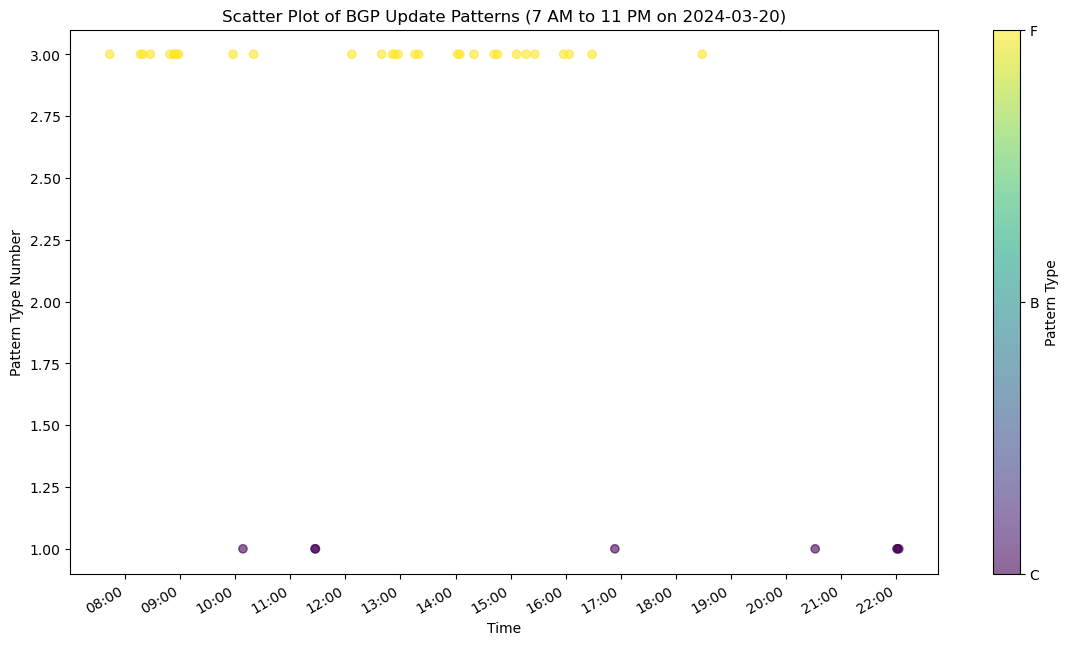

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('bgp_patterns.csv')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df['End Time'] = pd.to_datetime(df['End Time'])

df['Mid Time'] = df['Start Time'] + (df['End Time'] - df['Start Time']) / 2

pattern_type_map = {'F': 3, 'B': 2, 'C': 1}  
df['Pattern Type Num'] = df['Pattern Type'].map(pattern_type_map)

start_time = '2024-03-20 07:00:00'
end_time = '2024-03-20 23:00:00'
df_filtered = df[(df['Mid Time'] >= start_time) & (df['Mid Time'] <= end_time)]


plt.figure(figsize=(14, 8))


scatter = plt.scatter(df_filtered['Mid Time'], df_filtered['Pattern Type Num'],
                      c=df_filtered['Pattern Type Num'], cmap='viridis', alpha=0.6)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xlabel('Time')
plt.ylabel('Pattern Type Number')
plt.title('Scatter Plot of BGP Update Patterns (7 AM to 11 PM on 2024-03-20)')

cbar = plt.colorbar(scatter, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(['C', 'B', 'F']) 
cbar.set_label('Pattern Type')


plt.gcf().autofmt_xdate()


plt.show()
